<a href="https://colab.research.google.com/github/samsyano/Transfer-Learning-/blob/main/TransferLearning_Fine_Tuning01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Working with different fine tunning

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2023-07-29 19:12:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M  39.5MB/s    in 3.4s    

2023-07-29 19:12:15 (37.5 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2023-07-29 19:12:15--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-29 19:12:15 (83.7 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
from helper_functions import load_and_prep_image, make_confusion_matrix, pred_and_plot, create_tensorboard_callback, plot_loss_curves, compare_historys, unzip_data, walk_through_dir, calculate_results

In [ ]:
unzip_data("10_food_classes_1_percent.zip")

In [ ]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'

In [ ]:
# Create training and test directory paths

train_dir = "10_food_classes_1_percent/train"
test_dir= "10_food_classes_1_percent/test"

In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical",
                                                                 batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical",
                                                                 batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
print(tf.__version__)

2.12.0


### Adding data augmentation into the model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
# Create data augmentation stage

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255)
], name="data_augmentation")



### Visualize  data augmentation layer

(-0.5, 596.5, 494.5, -0.5)

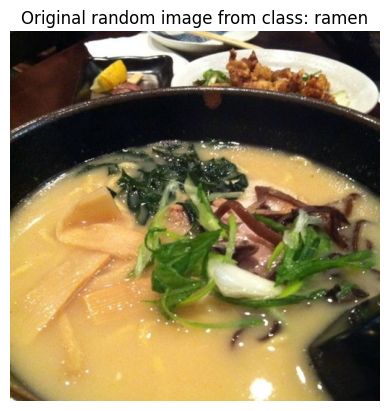

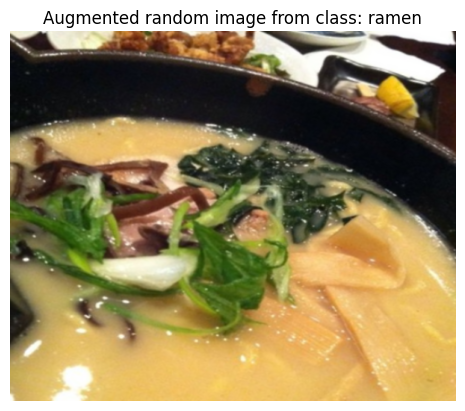

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image


# Read in the random image

img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False)

augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)

In [ ]:
# setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as layer
x = data_augmentation(inputs)

# Give base_model the inputs and don't train it
x = base_model(x, training=False)

# Pool output features
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# compile model
model_1.compile(loss="categorical_crossentropy",
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=["accuracy"])

history_1_percent = model_1.fit(train_data,
                                epochs=5,
                                steps_per_epoch=len(train_data),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230729-191235


Epoch 1/5
3/3 [==============================] - 20s 4s/step - loss: 2.4786 - accuracy: 0.0714 - val_loss: 2.2669 - val_accuracy: 0.1595
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.2203 - accuracy: 0.1857 - val_loss: 2.1362 - val_accuracy: 0.2237
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.9830 - accuracy: 0.3429 - val_loss: 2.0083 - val_accuracy: 0.3355
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8286 - accuracy: 0.4714 - val_loss: 1.9125 - val_accuracy: 0.4030
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.6796 - accuracy: 0.6286 - val_loss: 1.8092 - val_accuracy: 0.4901


In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainabl

In [ ]:
results_1 = model_1.evaluate(test_data)
results_1

79/79 [==============================] - 8s 98ms/step - loss: 1.8202 - accuracy: 0.4836


[1.8202476501464844, 0.483599990606308]

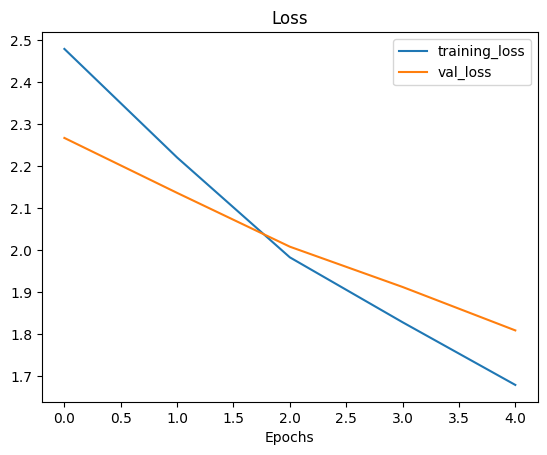

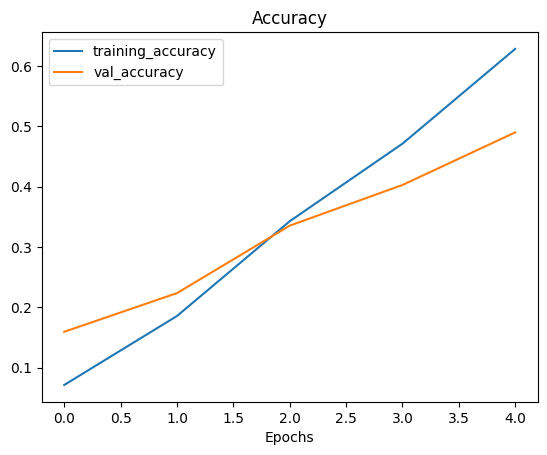

In [ ]:
plot_loss_curves(history_1_percent)

### Feature Extraction transfer learning model with 10% of data

In [ ]:
# Get the 10% data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip


--2023-07-29 19:13:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  42.3MB/s    in 4.5s    

2023-07-29 19:13:40 (35.8 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
unzip_data("10_food_classes_10_percent.zip")

train_dir_10p = "10_food_classes_10_percent/train"
test_dir_10p = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10p = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_10p,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical",
                                                                 batch_size=BATCH_SIZE)

test_data_10p = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir_10p,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical",
                                                                 batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


# Create data augmentation stage

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255)
], name="data_augmentation")



In [ ]:
# Setup the input shape to the model
input_shape = (224, 224, 3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) #augment training images
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)


# compile model
model_2.compile(loss="categorical_crossentropy",
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=["accuracy"])

# history_2 = model_2.fit(train_data,
#                                 epochs=5,
#                                 steps_per_epoch=len(train_data_10p),
#                                 validation_data=test_data_10p,
#                                 validation_steps=int(0.25 * len(test_data)),
#                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
#                                                                        experiment_name="1_percent_data_aug")])

In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### Creating a Model Checkpoint Call back
It intermittently saves the model


In [ ]:
# Set checkpoint path
checkpoint_path = "ten_percent_modelcheckpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1)

In [ ]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_2_data_aug = model_2.fit(train_data_10p,
                                epochs=initial_epochs,
                                validation_data=test_data_10p,
                                validation_steps=int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="10_percent_data_aug"),
                                           checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230729-191346
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9274 - accuracy: 0.3880
Epoch 1: saving model to ten_percent_modelcheckpoints_weights/checkpoint.ckpt
24/24 [==============================] - 25s 689ms/step - loss: 1.9274 - accuracy: 0.3880 - val_loss: 1.4010 - val_accuracy: 0.6809
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2683 - accuracy: 0.7187
Epoch 2: saving model to ten_percent_modelcheckpoints_weights/checkpoint.ckpt
24/24 [==============================] - 13s 521ms/step - loss: 1.2683 - accuracy: 0.7187 - val_loss: 0.9851 - val_accuracy: 0.7993
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9787 - accuracy: 0.7760
Epoch 3: saving model to ten_percent_modelcheckpoints_weights/checkpoint.ckpt
24/24 [==============================] - 14s 553ms/step - loss: 0.9787 - accuracy: 0.7760 - val_loss: 0.7951 - val_accuracy: 0.8207
Epoc

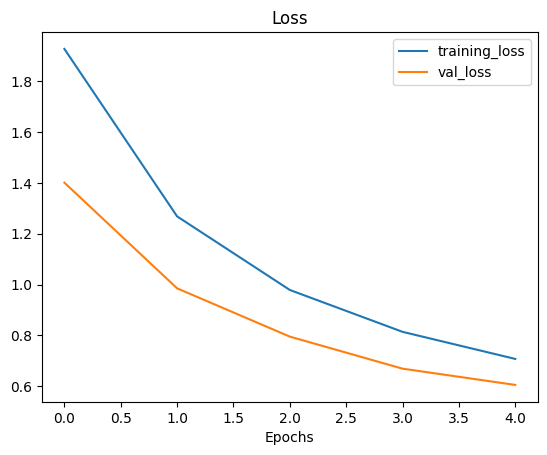

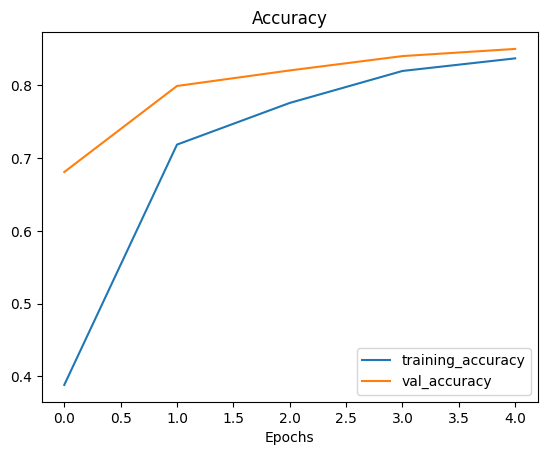

In [ ]:
plot_loss_curves(history_2_data_aug)

In [ ]:
model_2.evaluate(test_data_10p)

79/79 [==============================] - 7s 81ms/step - loss: 0.6175 - accuracy: 0.8480


[0.6175470948219299, 0.8479999899864197]

### Loading in checkpointed weights
returns a model to a specific checkpoint


In [ ]:
# load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
loaded_weights_model_results = model_2.evaluate(test_data_10p)

79/79 [==============================] - 8s 89ms/step - loss: 0.6175 - accuracy: 0.8480


In [ ]:
results_1_data_aug = model_2.evaluate(test_data)

79/79 [==============================] - 7s 81ms/step - loss: 0.6175 - accuracy: 0.8480


In [ ]:
results_1_data_aug == loaded_weights_model_results

False

In [ ]:
# check to see if loaded model results are very close to previous non-loaded model results
import numpy as np
np.isclose(np.array(results_1_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
results_1_data_aug, loaded_weights_model_results


([0.6175468564033508, 0.8479999899864197],
 [0.6175469160079956, 0.8479999899864197])

In [ ]:
# Layers in loaded model
model_2.layers

In [ ]:
# Check if layers are trainable
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7e873cc0f040> True
<keras.engine.sequential.Sequential object at 0x7e873c9f12a0> True
<keras.engine.functional.Functional object at 0x7e873c9acfa0> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7e873cc9d2a0> True
<keras.layers.core.dense.Dense object at 0x7e873c7c81f0> True


In [ ]:
# Check the trainable portion of the functional layer
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# Make the last 10 layers trainable
base_model.trainable = True

# Freeze all layers except last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False


# Recompile to implement the changes made on the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])


In [ ]:
# Check which layers are trainable

for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
print(len(model_2.trainable_variables))

12


In [ ]:
# Fit the model saving checkpoints every epoch
fine_tune_epochs = initial_epochs + 5

history_finetune_data_aug = model_2.fit(train_data_10p,
                                epochs=fine_tune_epochs,
                                validation_data=test_data_10p,
                                validation_steps=int(0.25 * len(test_data)),
                                initial_epoch=history_2_data_aug.epoch[-1],
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="10_percent_fine_tune_data")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_data/20230729-191541


Epoch 5/10
24/24 [==============================] - 24s 616ms/step - loss: 0.5927 - accuracy: 0.8413 - val_loss: 0.4740 - val_accuracy: 0.8618
Epoch 6/10
24/24 [==============================] - 12s 463ms/step - loss: 0.4617 - accuracy: 0.8720 - val_loss: 0.4569 - val_accuracy: 0.8602
Epoch 7/10
24/24 [==============================] - 11s 438ms/step - loss: 0.4328 - accuracy: 0.8787 - val_loss: 0.4354 - val_accuracy: 0.8586
Epoch 8/10
24/24 [==============================] - 11s 428ms/step - loss: 0.3921 - accuracy: 0.8813 - val_loss: 0.4215 - val_accuracy: 0.8553
Epoch 9/10
24/24 [==============================] - 9s 352ms/step - loss: 0.3350 - accuracy: 0.8987 - val_loss: 0.4812 - val_accuracy: 0.8355
Epoch 10/10
24/24 [==============================] - 14s 555ms/step - loss: 0.2983 - accuracy: 0.9067 - val_loss: 0.4263 - val_accuracy: 0.8569


In [ ]:
# Evaluate the fine-tuned model (model_3 which is fine-tuned model_2 with another 5 epochs)
results_fine_tune_10p = model_2.evaluate(test_data_10p)

79/79 [==============================] - 8s 90ms/step - loss: 0.4101 - accuracy: 0.8660


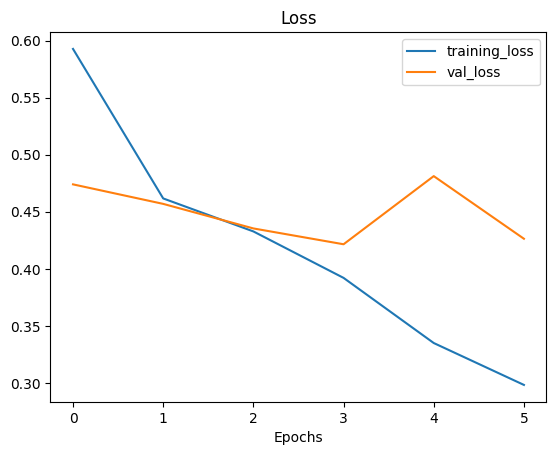

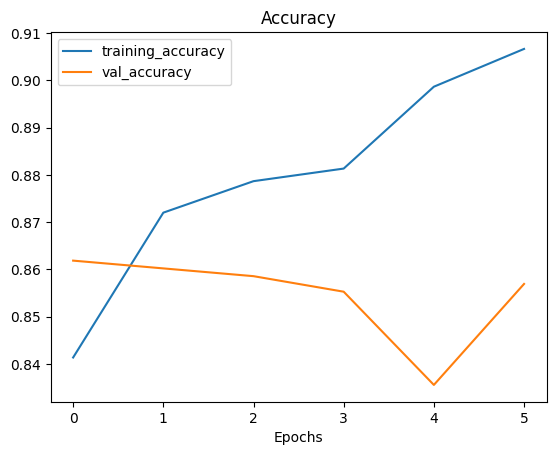

In [ ]:
plot_loss_curves(history_finetune_data_aug)

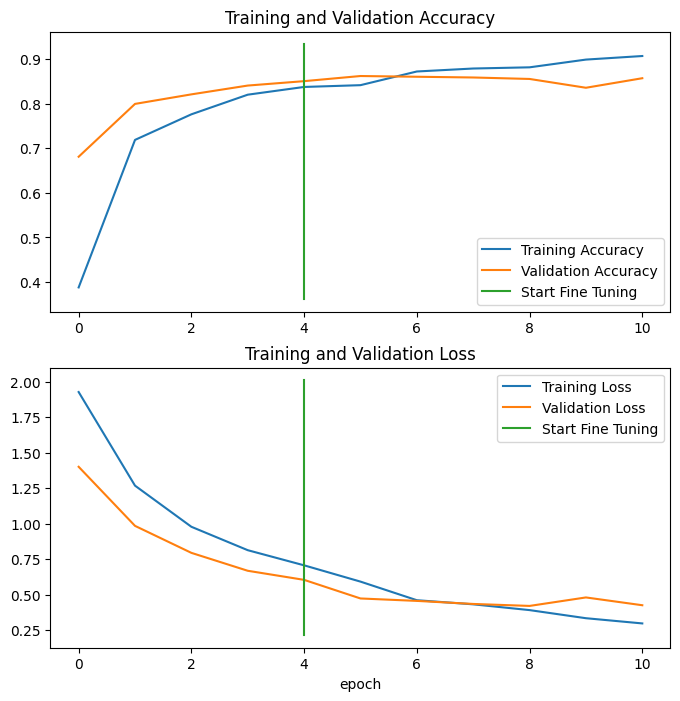

In [ ]:
# Create a function to compare training histories (The function is already created)

compare_historys(history_2_data_aug, history_finetune_data_aug, initial_epochs=5)

### Model-4: Fine-tunning an existing model on all the data


In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2023-07-29 19:17:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M  41.2MB/s    in 16s     

2023-07-29 19:17:46 (31.7 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [ ]:
unzip_data("10_food_classes_all_data.zip")

In [ ]:
# Setup training and test dir
train_all_data_dir = "10_food_classes_all_data/train"
test_all_data_dir = "10_food_classes_all_data/test"

In [ ]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 

In [ ]:
# Setup data input
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_all_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_all_data_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical")

test_all_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_all_data_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical")

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Evaluate previous model on new test data
model_2.evaluate(test_all_data)

79/79 [==============================] - 6s 70ms/step - loss: 0.4101 - accuracy: 0.8660


[0.41014209389686584, 0.8659999966621399]

In [ ]:
results_fine_tune_10p

[0.4101421535015106, 0.8659999966621399]

In [ ]:
# model_2.load_weights(checkpoint_path)

In [ ]:
model_2.evaluate(test_all_data)

79/79 [==============================] - 8s 90ms/step - loss: 0.4101 - accuracy: 0.8660


[0.4101421535015106, 0.8659999966621399]

In [ ]:
results_1_data_aug

[0.6175468564033508, 0.8479999899864197]

In [ ]:
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [ ]:
# Check which layer are trrainable in the model.

for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# Compile model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [ ]:
# Fit the model, train and fine-tune to the 100% training data
fine_tune_epochs = initial_epochs + 5

history_finetune_all_data = model_2.fit(train_all_data,
                                epochs=fine_tune_epochs,
                                validation_data=test_all_data,
                                validation_steps=int(0.25 * len(test_data)),
                                initial_epoch=history_2_data_aug.epoch[-1],
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="full_data_fine_tune")])

Saving TensorBoard log files to: transfer_learning/full_data_fine_tune/20230729-191927
Epoch 5/10
235/235 [==============================] - 68s 285ms/step - loss: 0.5384 - accuracy: 0.8323 - val_loss: 0.3646 - val_accuracy: 0.8947
Epoch 6/10
235/235 [==============================] - 62s 263ms/step - loss: 0.4729 - accuracy: 0.8485 - val_loss: 0.3511 - val_accuracy: 0.8964
Epoch 7/10
235/235 [==============================] - 52s 221ms/step - loss: 0.4268 - accuracy: 0.8611 - val_loss: 0.3215 - val_accuracy: 0.9013
Epoch 8/10
235/235 [==============================] - 52s 218ms/step - loss: 0.3862 - accuracy: 0.8757 - val_loss: 0.3350 - val_accuracy: 0.8997
Epoch 9/10
235/235 [==============================] - 48s 203ms/step - loss: 0.3561 - accuracy: 0.8865 - val_loss: 0.2925 - val_accuracy: 0.9128
Epoch 10/10
235/235 [==============================] - 47s 198ms/step - loss: 0.3304 - accuracy: 0.8908 - val_loss: 0.2904 - val_accuracy: 0.9128


In [ ]:
result_finetune_alldata = model_2.evaluate(test_all_data)
result_finetune_alldata

79/79 [==============================] - 8s 78ms/step - loss: 0.2690 - accuracy: 0.9140


[0.2690390348434448, 0.9139999747276306]

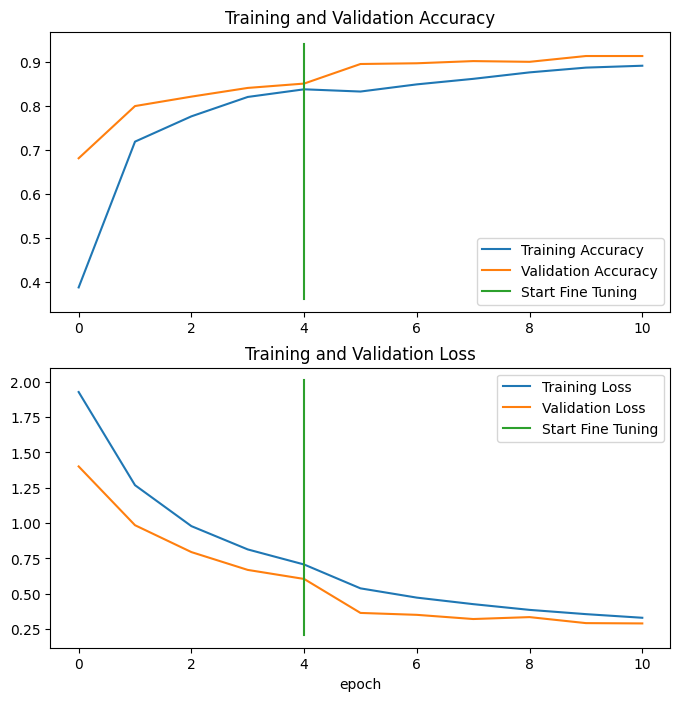

In [ ]:
compare_historys(history_2_data_aug, history_finetune_all_data, 5)

### Upload the result to TensorBoard

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning Experiments with 10 Food101 Classes" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot #exits the uploader once its finished uploading

2023-07-29 19:37:48.977772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   FGN-CMW-QMR



New experiment created. View your TensorBoard at: https://tensorboard.dev/

In [ ]:
# View all of the uploaded TensorBoard.dev experiment (public)
!tensorboard dev list



2023-07-29 21:47:49.426917: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-29 21:47:50.462402: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

C

In [ ]:
!tensorboard dev list

2023-07-29 21:49:36.901135: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-29 21:49:40.393208: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/alf8q6oJRvqv93w2V6UYLw/
	Name                 Transfer Learning Experiments with 10 Food101 Classes
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning
	Id                   alf8q6oJRvqv93w2V6UYLw
	Created              2023-07-29 19:39:21 (2 hours ago)
	Updated              2023-07-29 19:39:32 (2 hours ago)
	Runs                 15
	Tags                 5
	Scalars              228
	Tensor bytes         0
	Binary object bytes  7429630
Total: 1 experiment(s)


In [ ]:
## To delete an experiment
# !tensorboard dev delete --experiment_id alf8q6oJRvqv93w2V6UYLw